In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage

In [19]:
hokie_img = '/content/drive/MyDrive/Colab Notebooks/Learning Based Computer Vision/hokie.jpg'

img = cv2.imread(hokie_img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [20]:
kernel_size = 49
std = [1, math.sqrt(2), 2, 2*math.sqrt(2)]
gaussian_fl = np.zeros((4,kernel_size,kernel_size))

def gaussian(x, y, std_deviation):
  return (1/2*math.pi*math.pow(std_deviation, 2))*math.pow(math.e, -1*((math.pow(x,2)) + math.pow(y,2))/2*(math.pow(std_deviation, 2)))

In [21]:
#vectorized form of gaussian
def gaussian(x, y, std_deviationX, std_deviationY=None):
    if std_deviationY is None:
        std_deviationY = std_deviationX

    A = 1 / (2 * math.pi * std_deviationX * std_deviationY)

    return A * np.exp(-0.5 * ((x**2 / std_deviationX**2) + (y**2 / std_deviationY**2)))


size = 49
half = size // 2
x, y = np.meshgrid(np.linspace(-half, half, size),
                   np.linspace(-half, half, size))

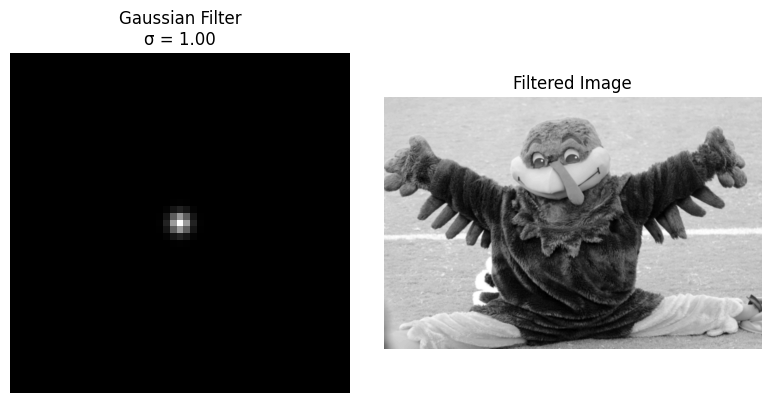

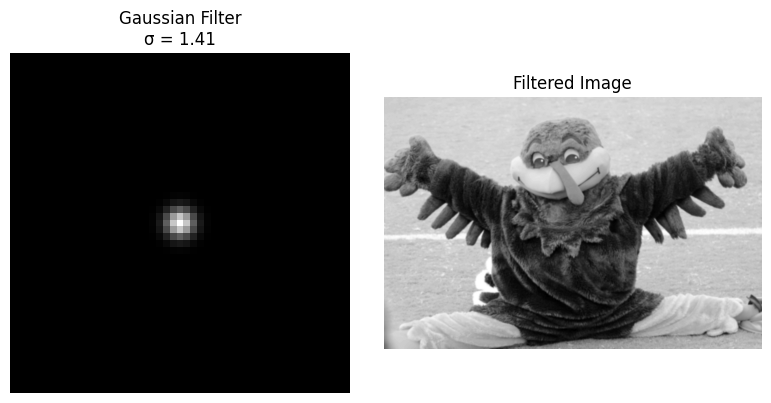

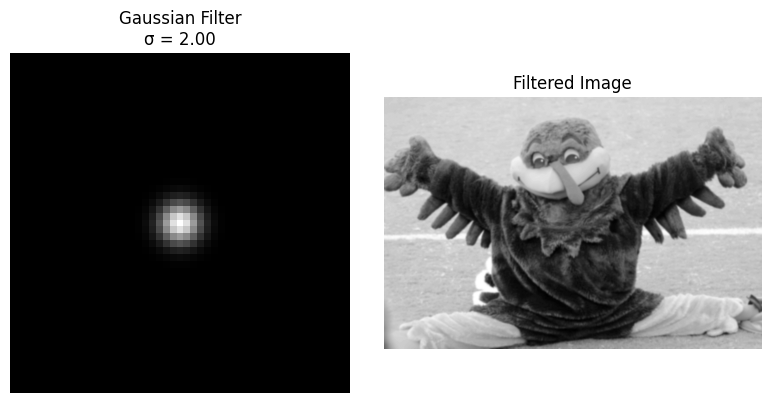

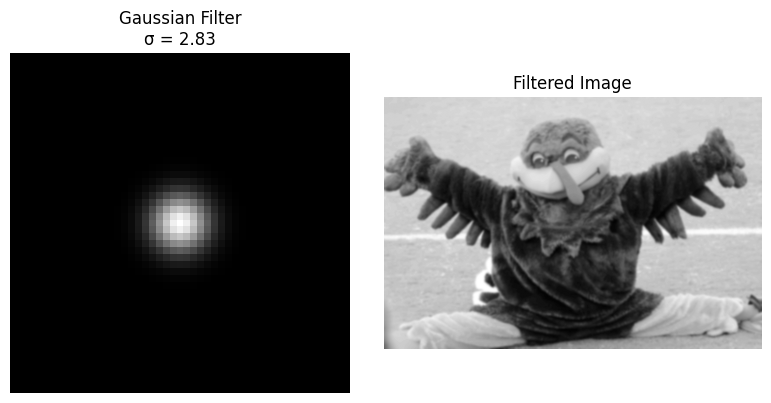

In [22]:
#create the Gaussian filters with std 1, sqrt(2), 2, 2sqrt(2) using a vectorized form
for i in range(len(gaussian_fl)):
  gaussian_fl[i] = gaussian(x, y, std[i])

gaussian_fl /= np.sum(gaussian_fl)
gaussian_fl_image = [ndimage.convolve(gray, filter) for filter in gaussian_fl]

for i in range(len(gaussian_fl)):
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))

  # left: Gaussian filter
  axes[0].imshow(gaussian_fl[i], cmap='gray', interpolation='nearest')
  axes[0].set_title(f"Gaussian Filter\nσ = {std[i]:.2f}")
  axes[0].axis('off')

  # right: Filtered image
  axes[1].imshow(gaussian_fl_image[i], cmap='gray')
  axes[1].set_title("Filtered Image")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()



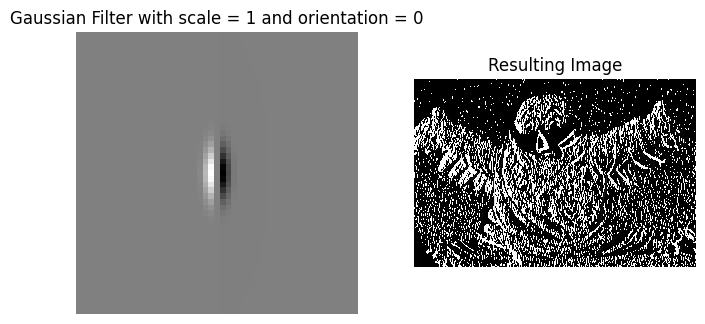

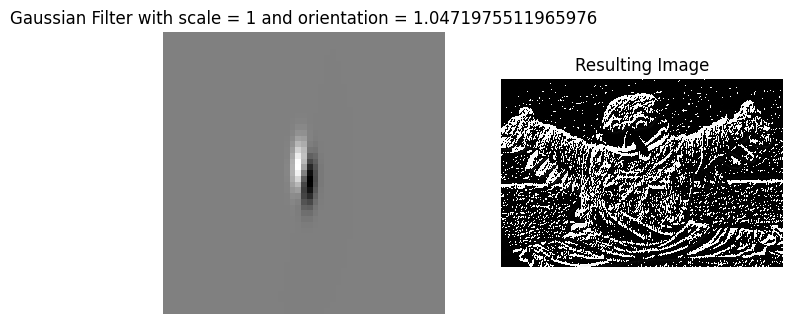

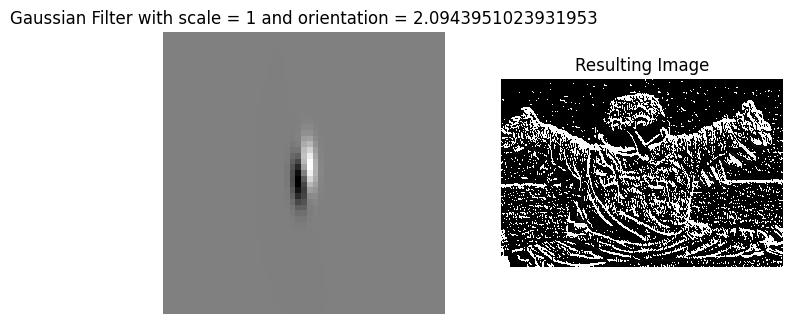

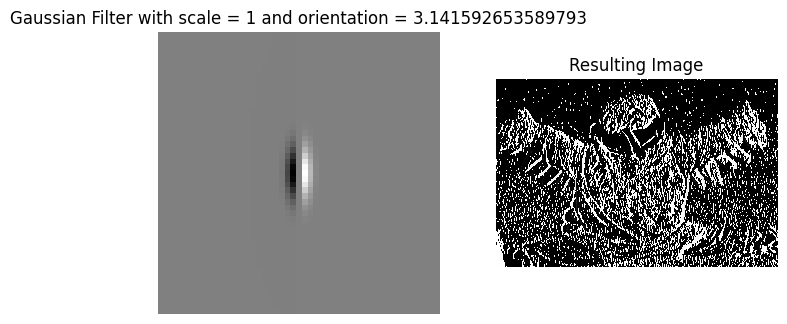

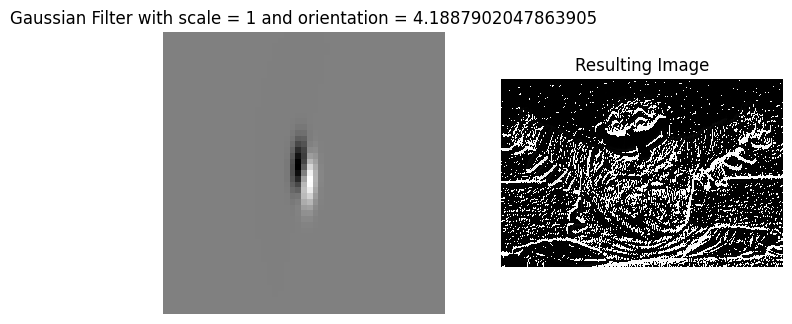

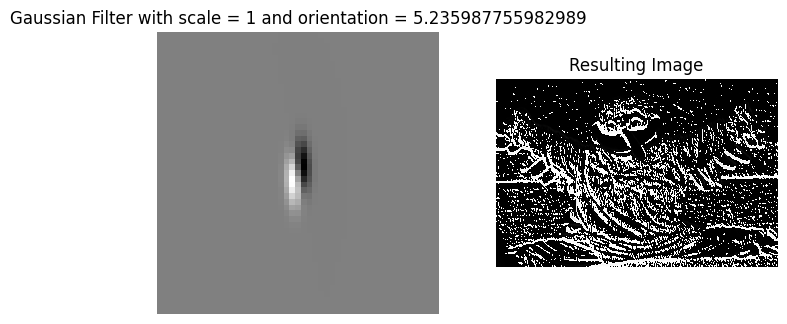

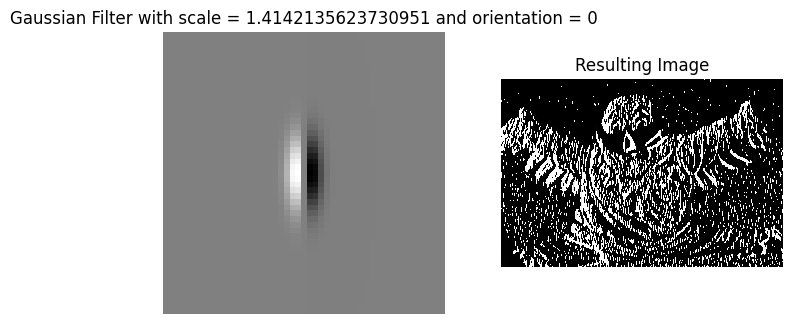

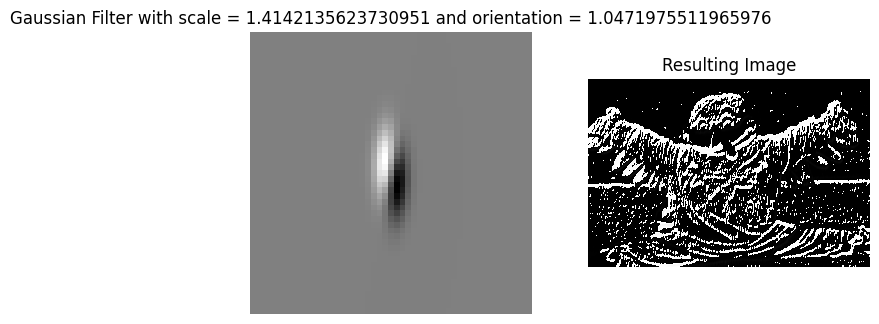

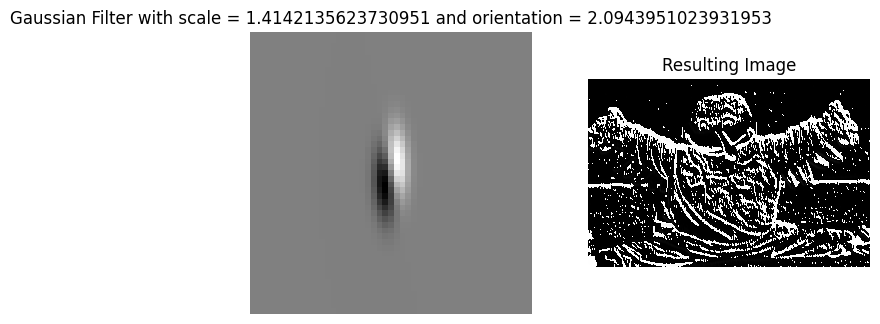

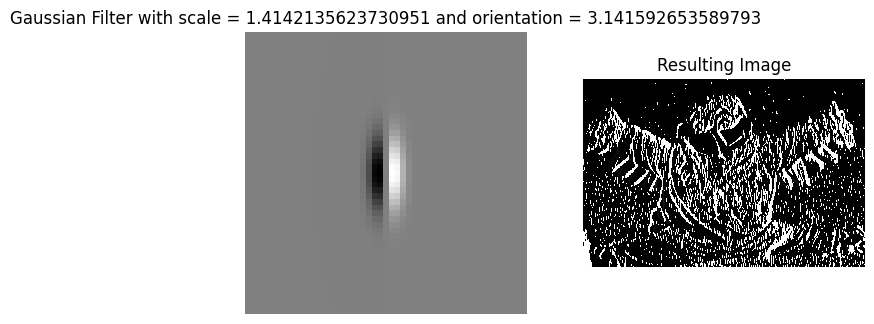

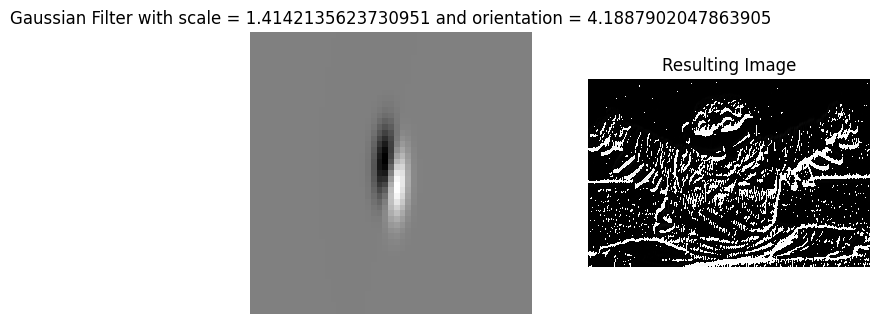

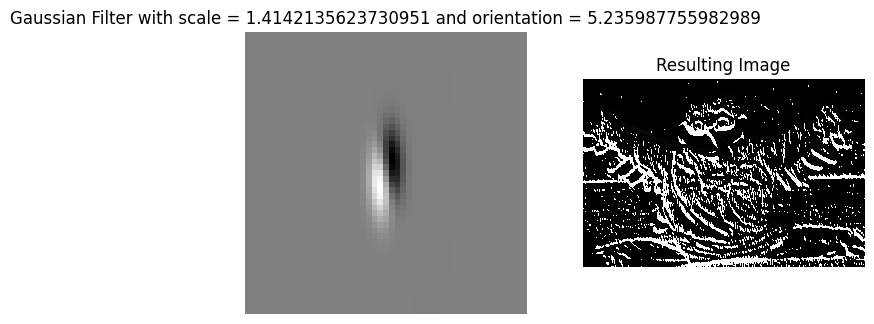

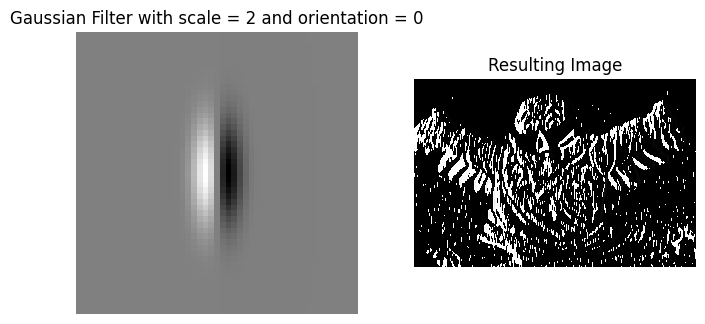

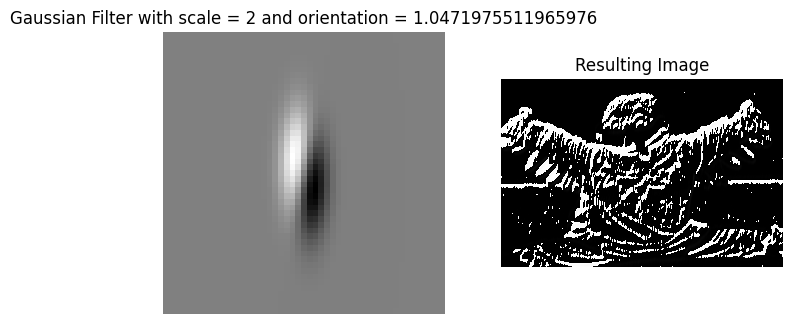

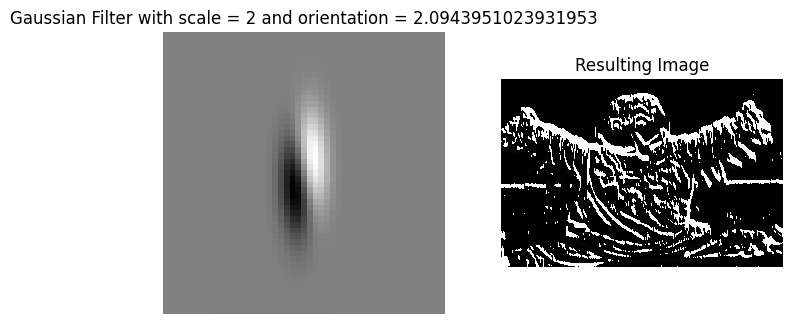

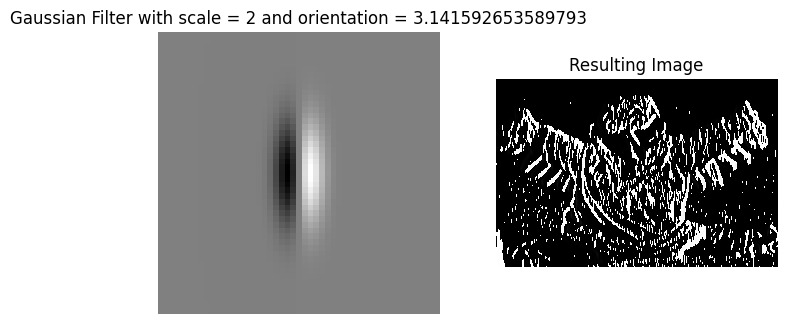

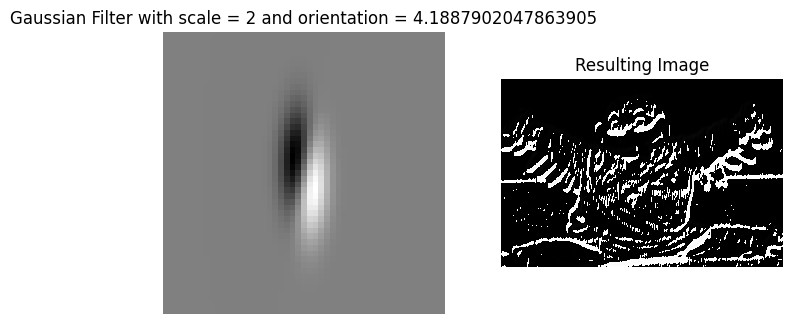

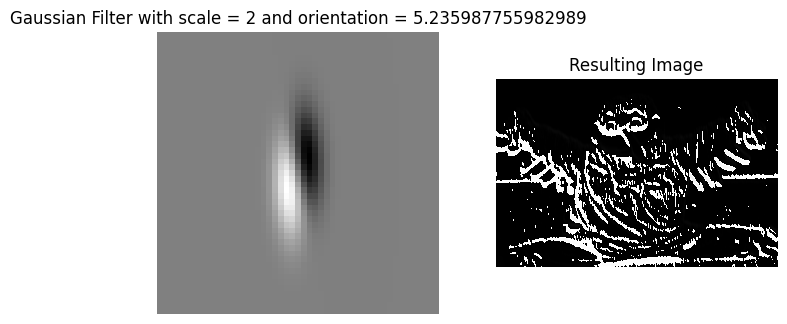

In [23]:
#vectorized form of first and second derivative Gaussian filters
def partial_x_gaussian(x, y, std_deviationX, std_deviationY):
  if std_deviationY == None:
    std_deviationY = std_deviationX
  return (-x / std_deviationX**2) * gaussian(x, y, std_deviationX, std_deviationY)

def partial_y_gaussian(x, y, std_deviationX, std_deviationY):
  if std_deviationY == None:
    std_deviationY = std_deviationX
  return (-y / std_deviationY**2) * gaussian(x, y, std_deviationX, std_deviationY)

def orientation(x,y, std_deviationX, std_deviationY, angles):
  if std_deviationY == None:
    std_deviationY = std_deviationX

  cos = np.cos(angles)[:,None, None]
  sin = np.sin(angles)[:,None, None]

  return cos*partial_x_gaussian(x,y, std_deviationX, std_deviationY)[None,:,:] + sin*partial_y_gaussian(x,y, std_deviationX, std_deviationY)[None,:,:]

angles = [0, math.pi/3, 2*math.pi/3, math.pi, 4*math.pi/3, 5*math.pi/3]

first_derv_gaussian_fl = np.zeros((3, 6, 49, 49))

for i in range(len(first_derv_gaussian_fl)):# only the first three
      first_derv_gaussian_fl[i] = orientation(x,y, std[i], 3*std[i], angles)

# first_derv_gaussian_fl /= np.sum(first_derv_gaussian_fl)

first_derv_gaussian_fl_image = np.zeros((3, 6, 800, 1200))

for i in range(len(first_derv_gaussian_fl)):
  for j in range(len(first_derv_gaussian_fl[i])):
    first_derv_gaussian_fl_image[i][j] = ndimage.convolve(gray, first_derv_gaussian_fl[i][j])


for i in range(len(first_derv_gaussian_fl)):
  for j in range(len(first_derv_gaussian_fl[i])):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].set_title(f"Gaussian Filter with scale = {std[i]} and orientation = {angles[j]}")
    axes[0].imshow(first_derv_gaussian_fl[i][j], cmap='gray', interpolation='nearest')
    # axes[0].set_title(f"First Derivative Gaussian Filter\nσ = {std[i]:.2f}")
    axes[0].axis('off')

    axes[1].imshow(first_derv_gaussian_fl_image[i][j], cmap='gray', interpolation='nearest')
    axes[1].set_title("Resulting Image")
    axes[1].axis('off')
    plt.show()


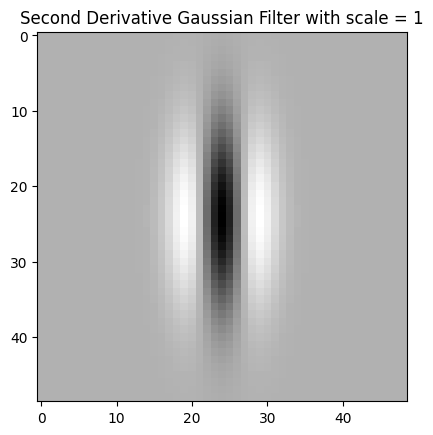

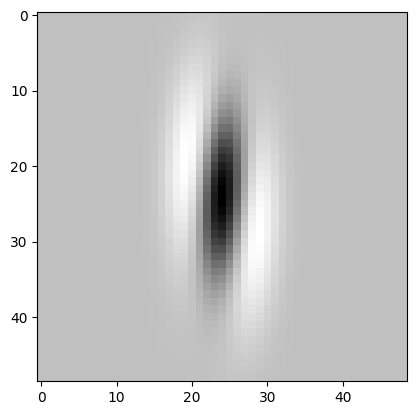

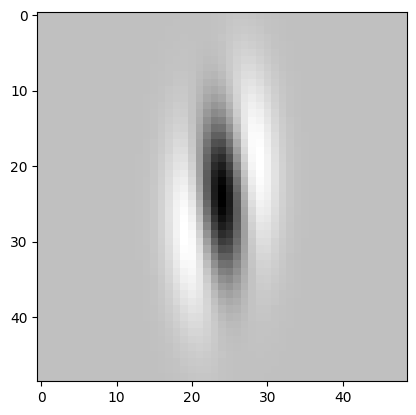

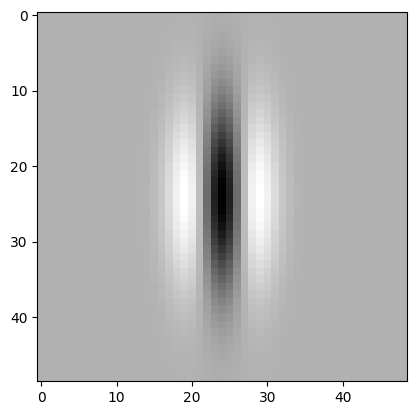

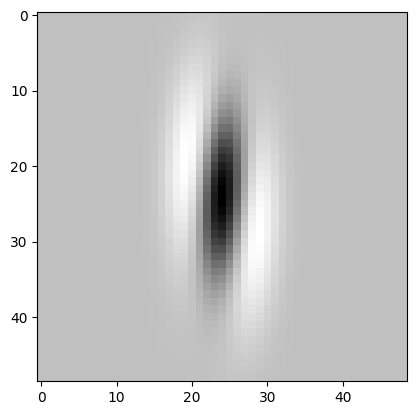

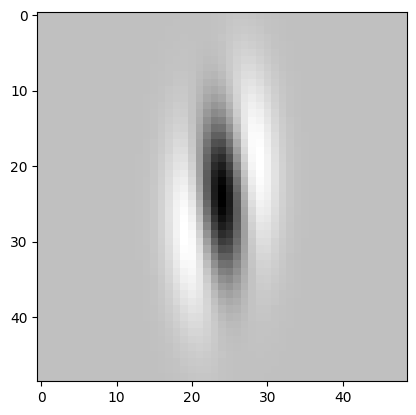

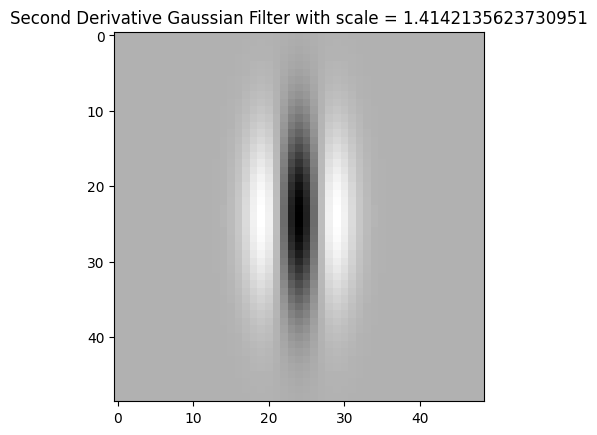

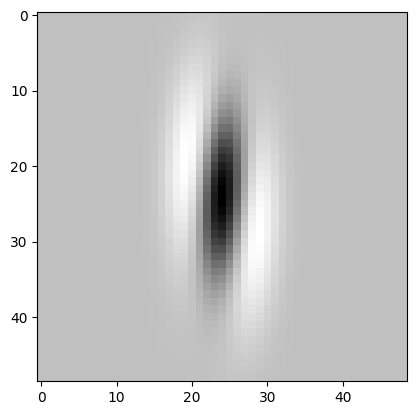

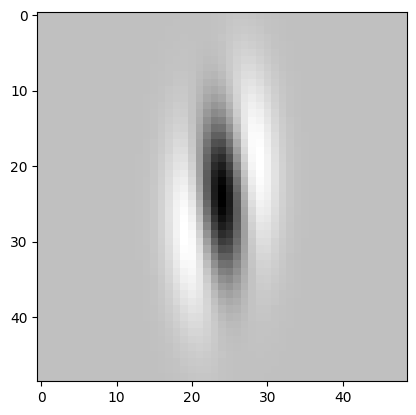

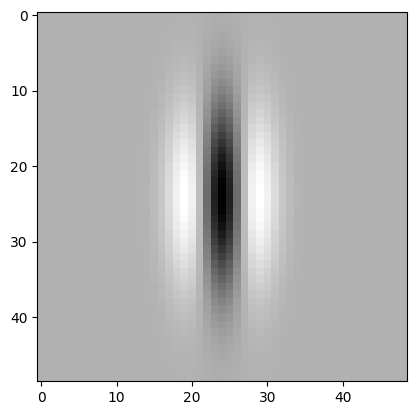

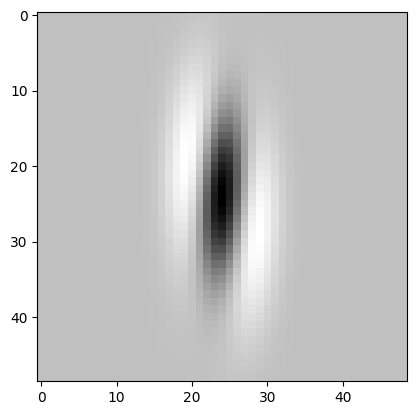

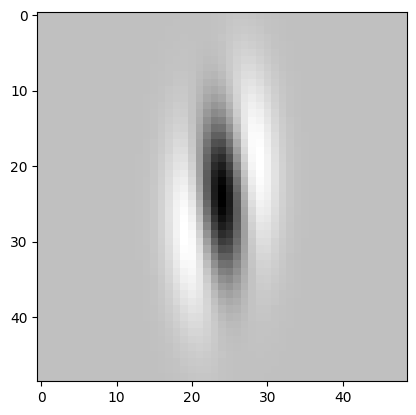

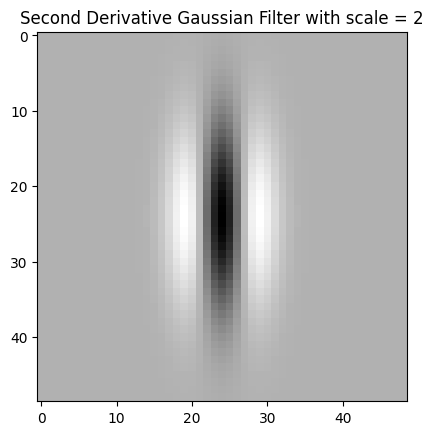

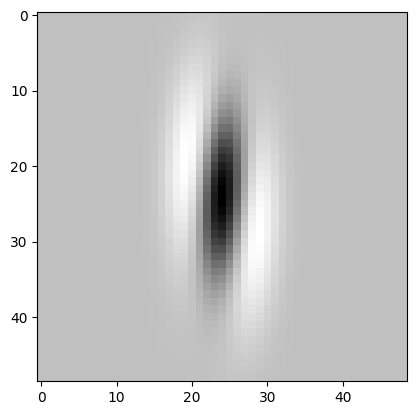

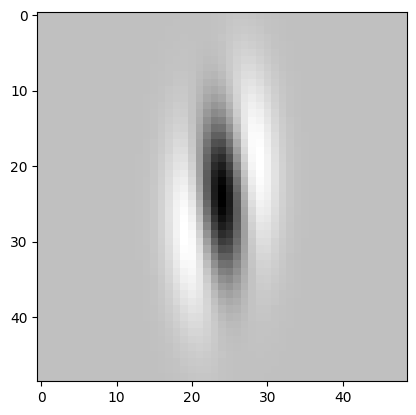

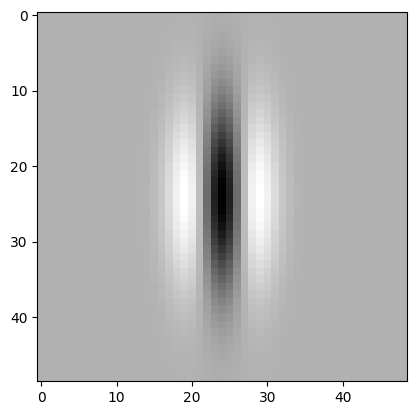

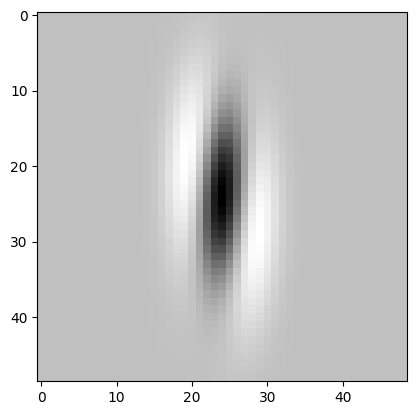

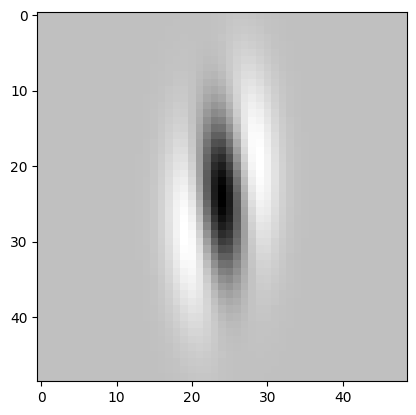

In [24]:
def partial_xx_gaussian(x, y, std_deviationX, std_deviationY=None):
    if std_deviationY is None:
        std_deviationY = std_deviationX
    G = gaussian(x, y, std_deviationX, std_deviationY)
    return ((x**2 / std_deviationX**4) - (1 / std_deviationX**2)) * G

def partial_yy_gaussian(x, y, std_deviationX, std_deviationY=None):
    if std_deviationY is None:
        std_deviationY = std_deviationX
    G = gaussian(x, y, std_deviationX, std_deviationY)
    return ((y**2 / std_deviationY**4) - (1 / std_deviationY**2)) * G

def partial_xy_gaussian(x, y, std_deviationX, std_deviationY=None):
    if std_deviationY is None:
        std_deviationY = std_deviationX
    G = gaussian(x, y, std_deviationX, std_deviationY)
    return (x * y / (std_deviationX**2 * std_deviationY**2)) * G


def second_orientation(x,y, std_deviationX, std_deviationY, angles):
  if std_deviationY == None:
    std_deviationY = std_deviationX
  cos = np.cos(angles)[:,None, None]
  sin = np.sin(angles)[:,None, None]

  return partial_xx_gaussian(x, y, std_deviationX, std_deviationY)[None,:,:] * cos**2 + \
  partial_xy_gaussian(x, y, std_deviationX, std_deviationY)[None,:,:] * cos * sin + \
  partial_yy_gaussian(x, y, std_deviationX, std_deviationY)[None,:,:] * sin**2


second_derv_gaussian_fl = np.zeros((3, 6, 49, 49))

for i in range(len(first_derv_gaussian_fl)):
  for j in std:
      second_derv_gaussian_fl[i] = second_orientation(x,y, j, 3*j, angles)


for i in range(len(second_derv_gaussian_fl)):
  plt.title(f"Second Derivative Gaussian Filter with scale = {std[i]}")
  for j in range(len(second_derv_gaussian_fl[i])):
    plt.imshow(second_derv_gaussian_fl[i][j], cmap='gray', interpolation='nearest')
    # plt.colorbar(label='Value')
    plt.show()

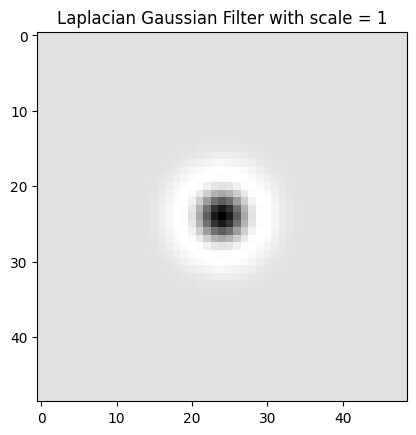

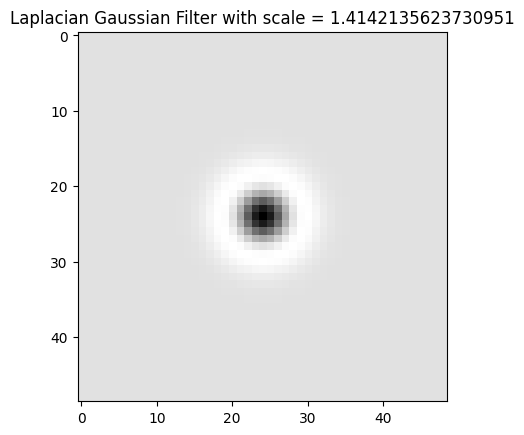

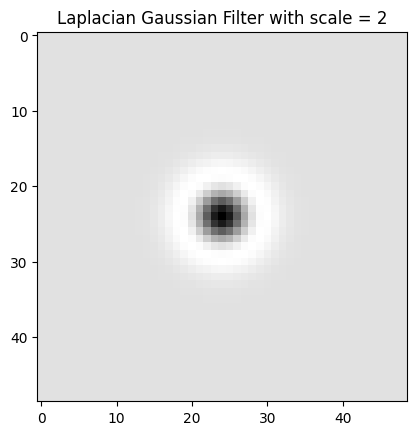

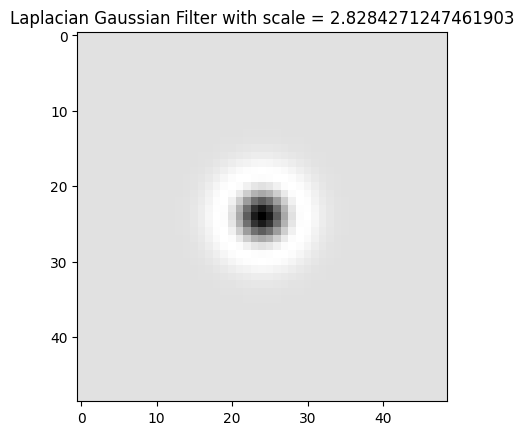

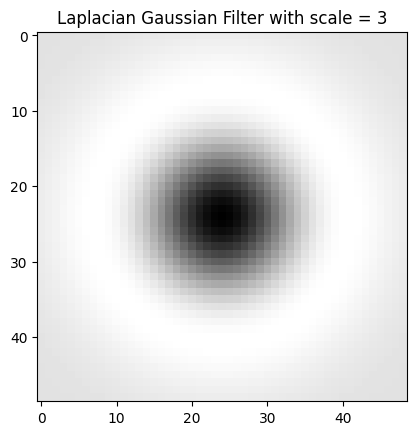

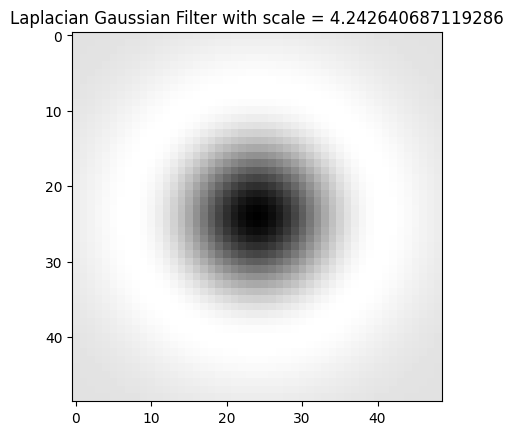

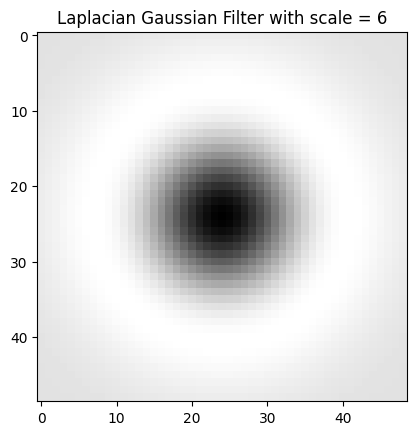

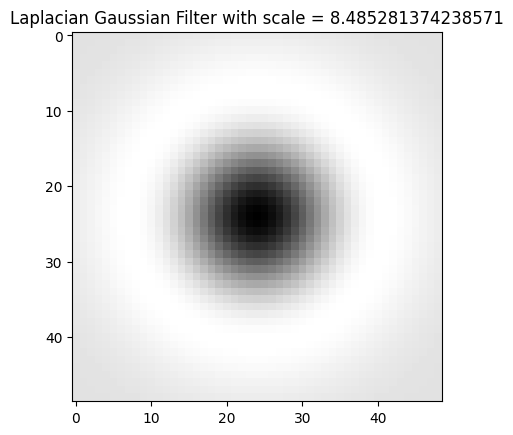

In [25]:
def laplacian_gaussian(x,y, std_deviationX, std_deviationY=None):
  if std_deviationY == None:
    std_deviationY = std_deviationX
  return partial_xx_gaussian(x, y, std_deviationX, std_deviationY) + partial_yy_gaussian(x, y, std_deviationX, std_deviationY)

laplacian_derv_gaussian_fl = np.zeros((2, 4, 49, 49))

for j in std:
  laplacian_derv_gaussian_fl[0] = laplacian_gaussian(x, y, j)

for j in std:
  laplacian_derv_gaussian_fl[1] = laplacian_gaussian(x, y, j*3)

for i in range(len(laplacian_derv_gaussian_fl[0])):
  plt.title(f"Laplacian Gaussian Filter with scale = {std[i]}")
  plt.imshow(laplacian_derv_gaussian_fl[0][i], cmap='gray', interpolation='nearest')
    # plt.colorbar(label='Value')
  plt.show()

for i in range(len(laplacian_derv_gaussian_fl[1])):
  plt.title(f"Laplacian Gaussian Filter with scale = {std[i] * 3}")
  plt.imshow(laplacian_derv_gaussian_fl[1][i], cmap='gray', interpolation='nearest')
    # plt.colorbar(label='Value')
  plt.show()

Start of Fourier Transform

In [26]:
import scipy

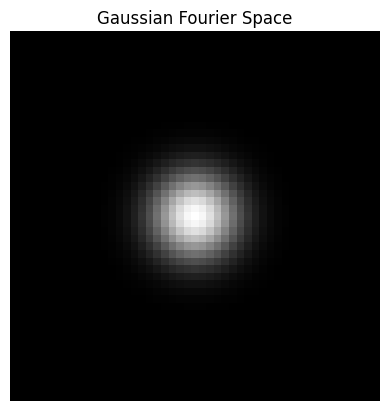

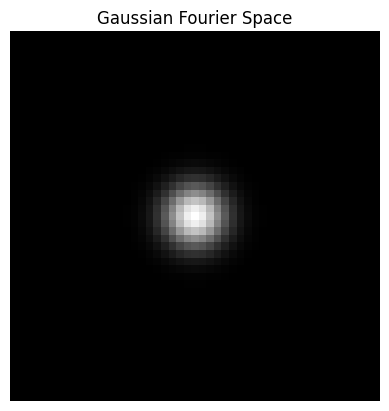

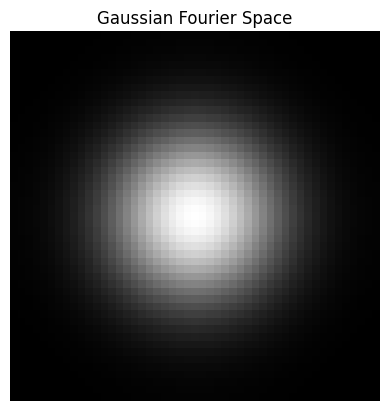

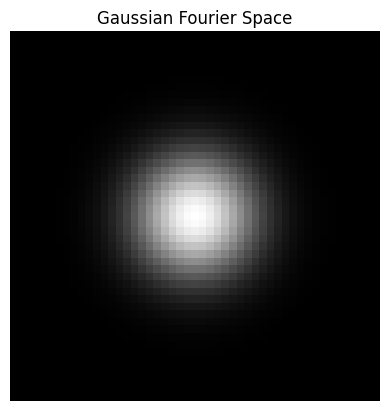

In [27]:
#2D Fourier Transform of Gaussian
fourier_gaussian = scipy.fft.fft2(gaussian_fl)
fourier_gaussian = scipy.fft.fftshift(fourier_gaussian)

for i in range(len(fourier_gaussian)):
  # left: Gaussian filter
  plt.imshow(np.abs(fourier_gaussian[i]), cmap='gray', interpolation='nearest')
  plt.title(f"Gaussian Fourier Space")
  plt.axis('off')

  plt.show()


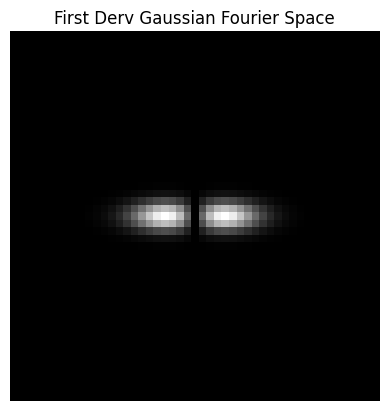

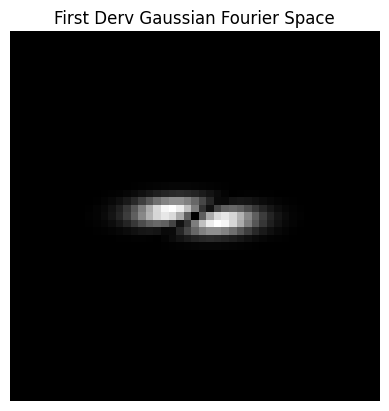

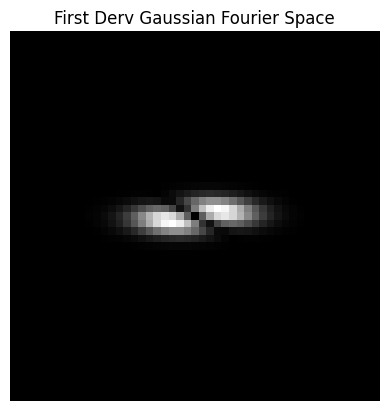

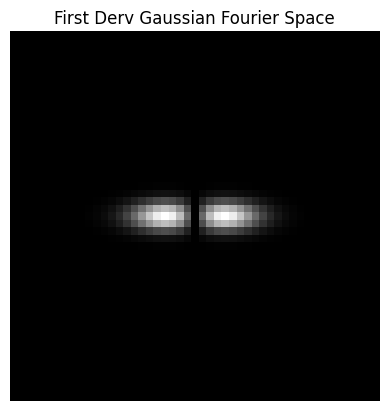

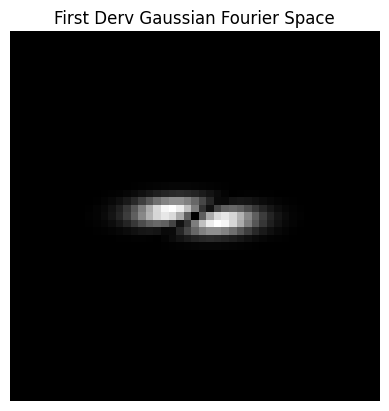

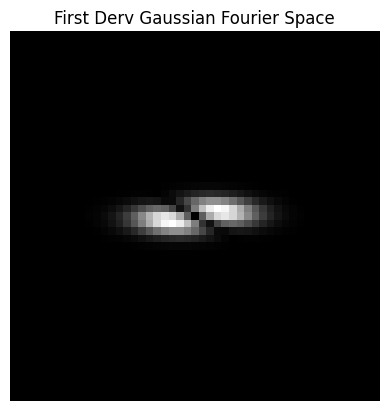

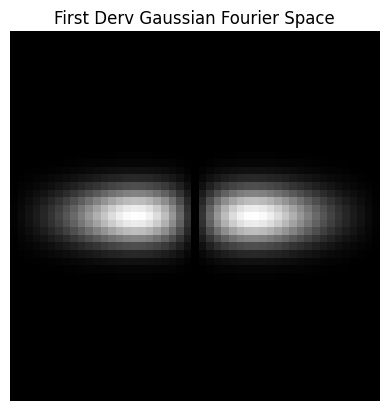

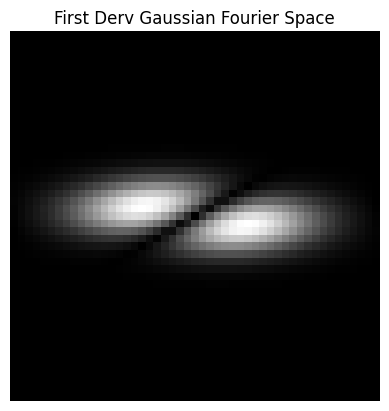

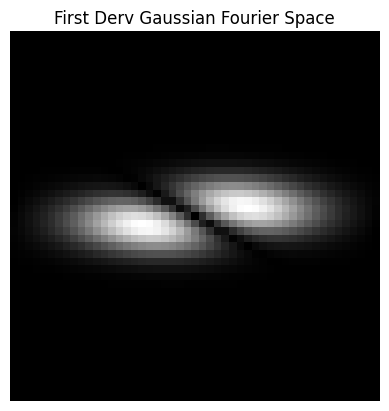

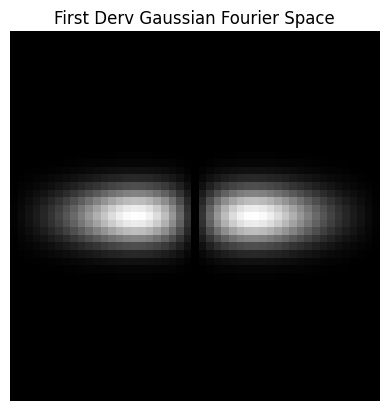

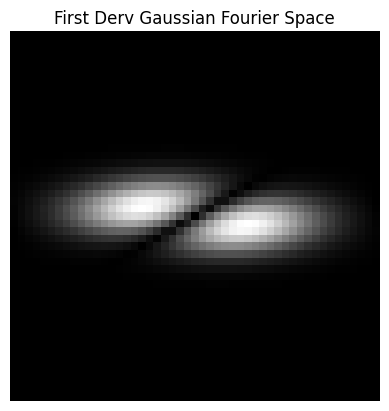

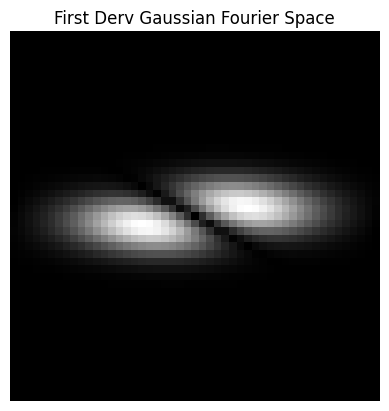

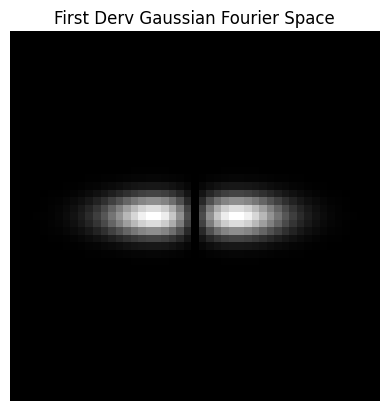

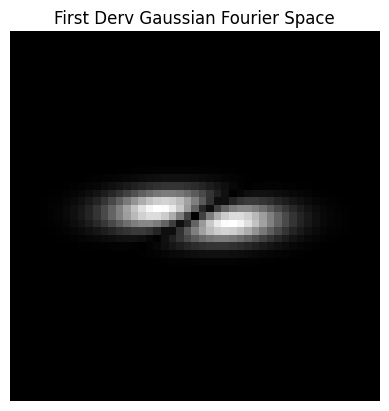

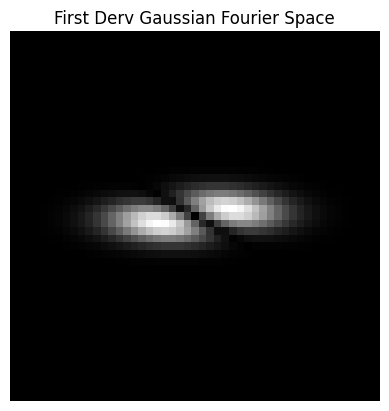

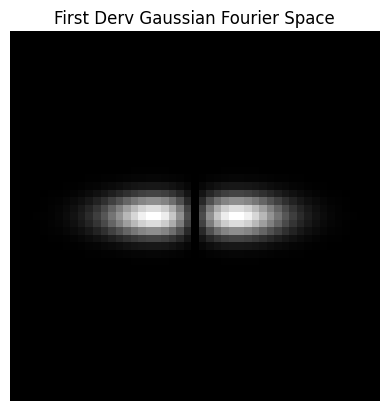

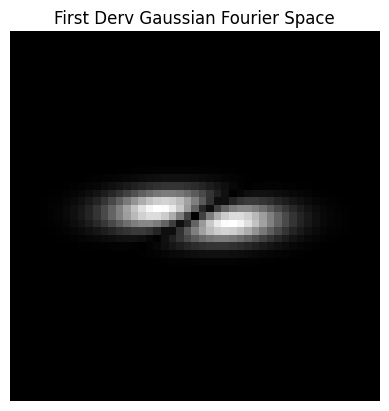

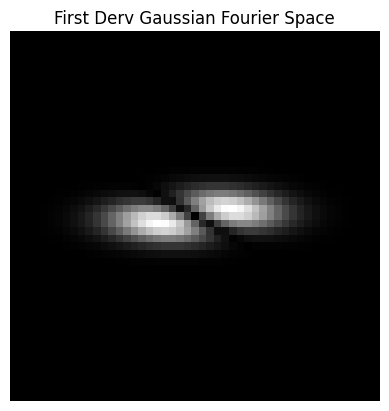

In [28]:
#2D Fourier Transform of First Derv Gaussian
first_derv_fourier_gaussian = scipy.fft.fft2(first_derv_gaussian_fl)
first_derv_fourier_gaussian = scipy.fft.fftshift(first_derv_fourier_gaussian)

for i in range(len(first_derv_fourier_gaussian)):
  for j in range(len(first_derv_fourier_gaussian[i])):
    plt.imshow(np.abs(first_derv_fourier_gaussian[i][j]), cmap='gray', interpolation='nearest')
    plt.title(f"First Derv Gaussian Fourier Space")
    plt.axis('off')

    plt.show()

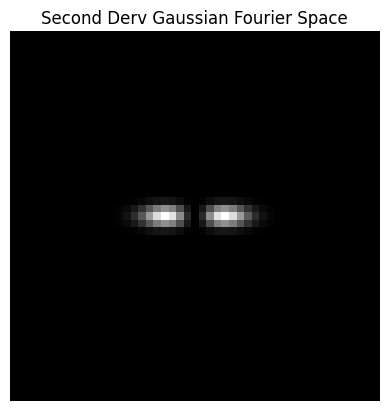

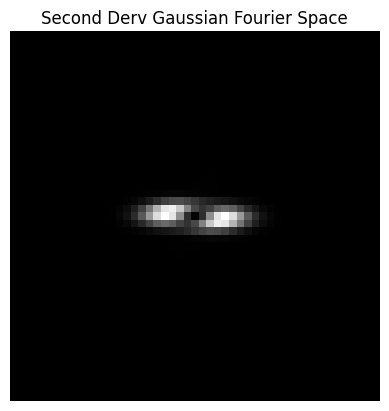

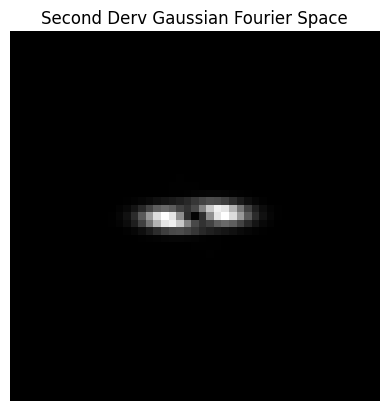

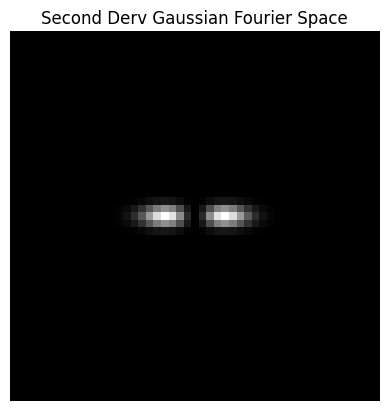

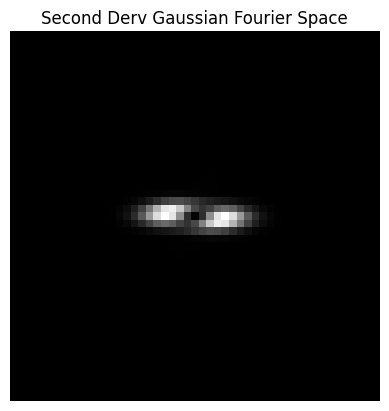

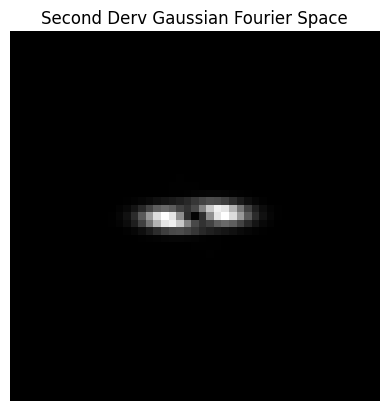

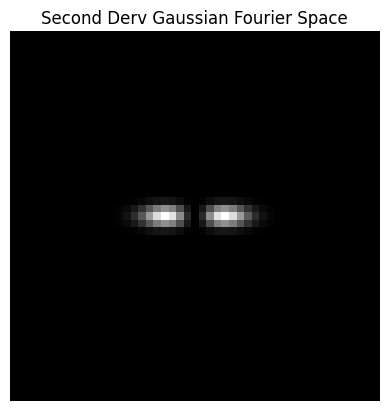

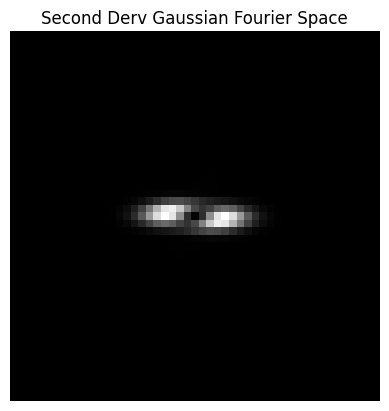

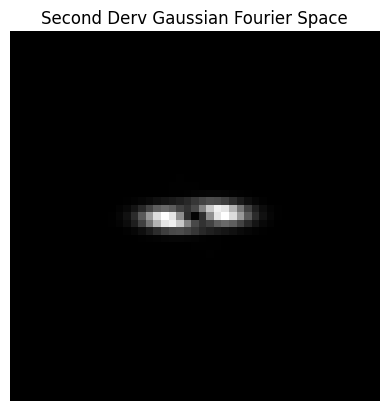

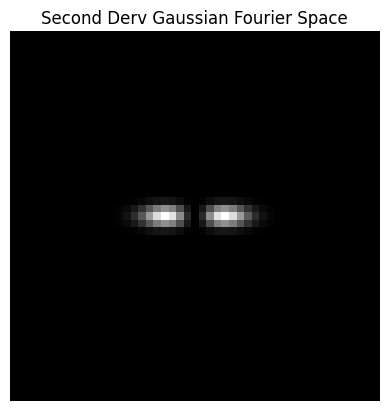

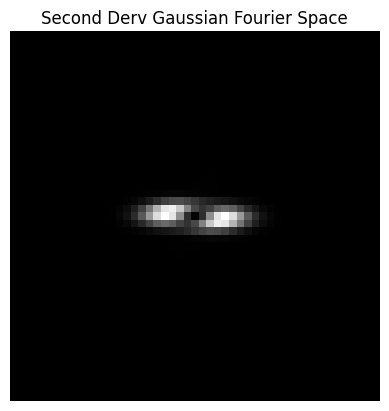

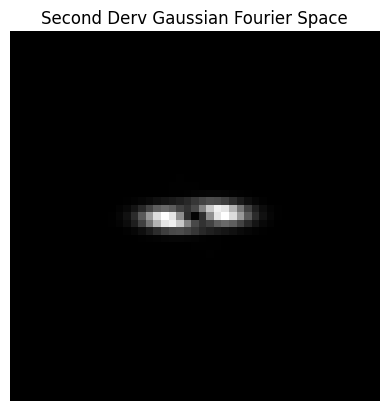

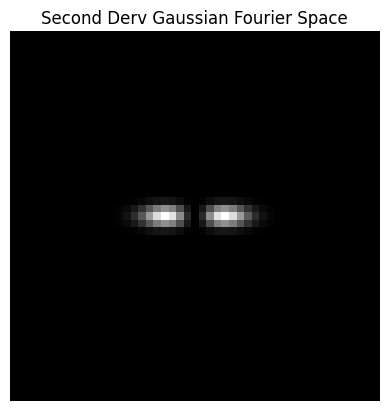

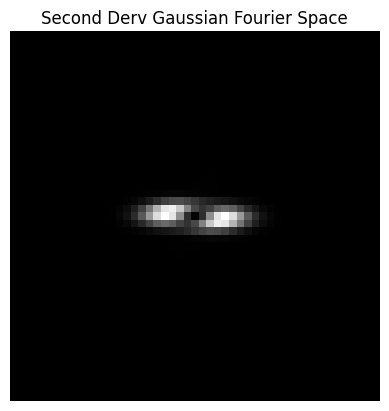

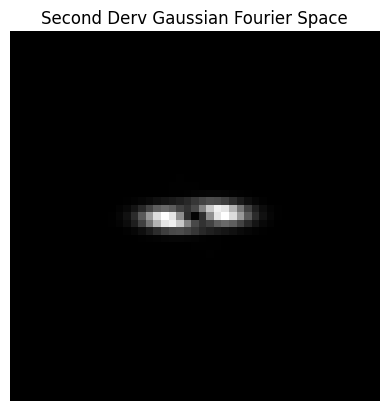

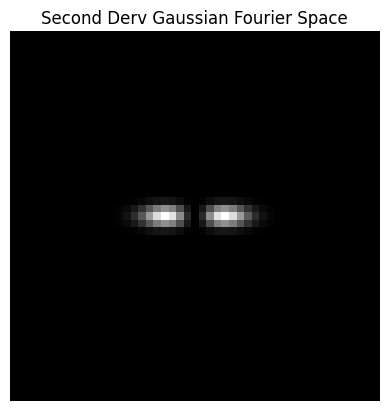

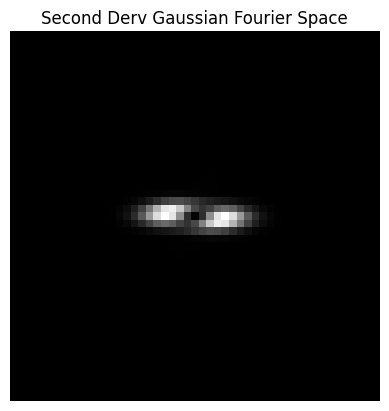

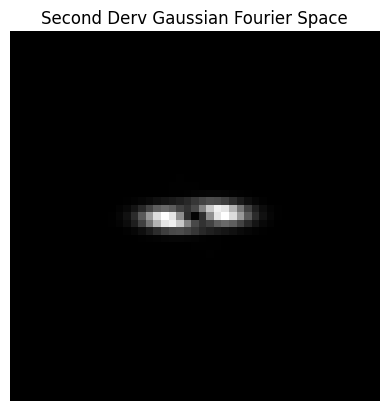

In [29]:
#2D Fourier Transform of Second Derv Gaussian
second_derv_fourier_gaussian = scipy.fft.fft2(second_derv_gaussian_fl)
second_derv_fourier_gaussian = scipy.fft.fftshift(second_derv_fourier_gaussian)

for i in range(len(second_derv_fourier_gaussian)):
  for j in range(len(second_derv_fourier_gaussian[i])):
    plt.imshow(np.abs(second_derv_fourier_gaussian[i][j]), cmap='gray', interpolation='nearest')
    plt.title(f"Second Derv Gaussian Fourier Space")
    plt.axis('off')

    plt.show()

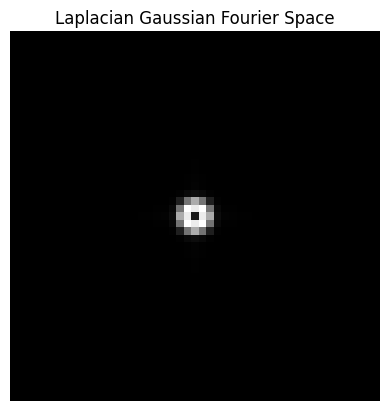

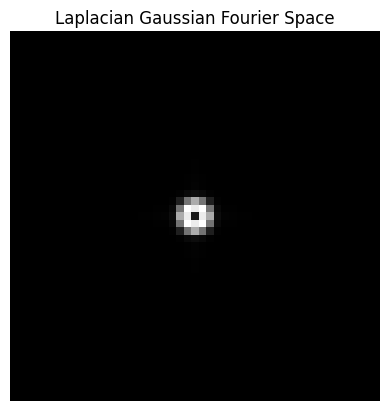

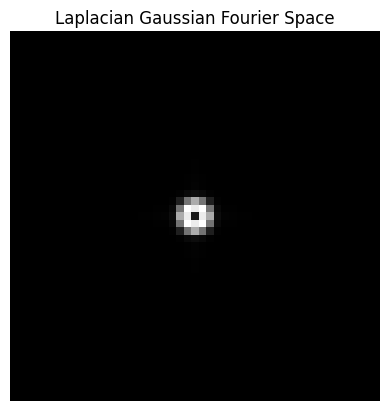

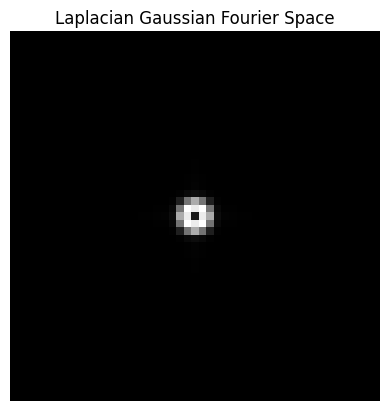

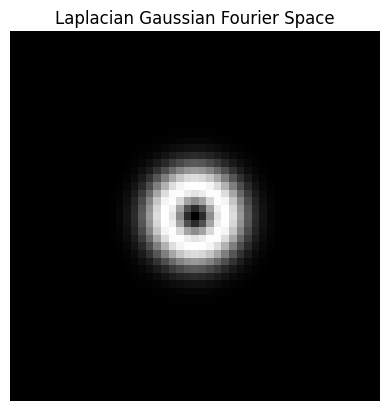

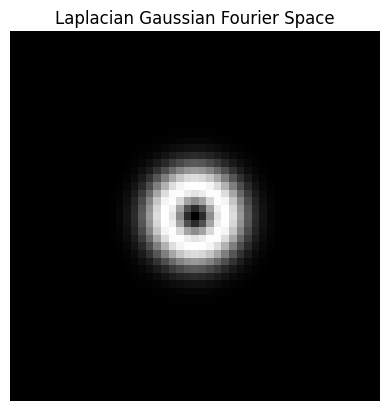

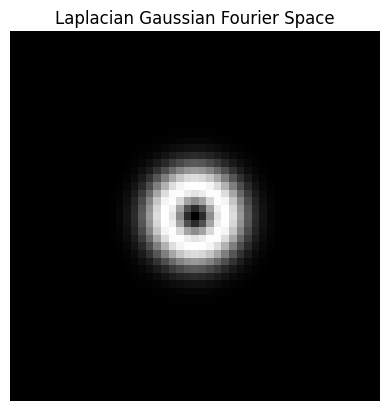

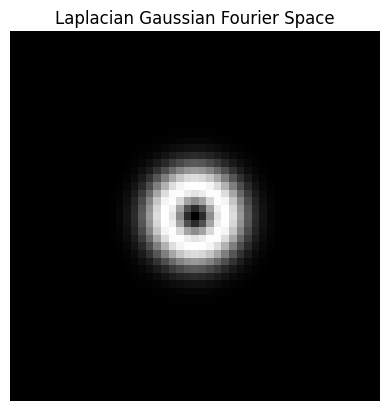

In [30]:
#2D Fourier Transform of laplacian Derv Gaussian
laplacian_derv_fourier_gaussian = scipy.fft.fft2(laplacian_derv_gaussian_fl)
laplacian_derv_fourier_gaussian = scipy.fft.fftshift(laplacian_derv_fourier_gaussian)

for i in range(len(laplacian_derv_fourier_gaussian)):
  for j in range(len(laplacian_derv_fourier_gaussian[i])):
    plt.imshow(np.abs(laplacian_derv_fourier_gaussian[i][j]), cmap='gray', interpolation='nearest')
    plt.title(f"Laplacian Gaussian Fourier Space")
    plt.axis('off')

    plt.show()

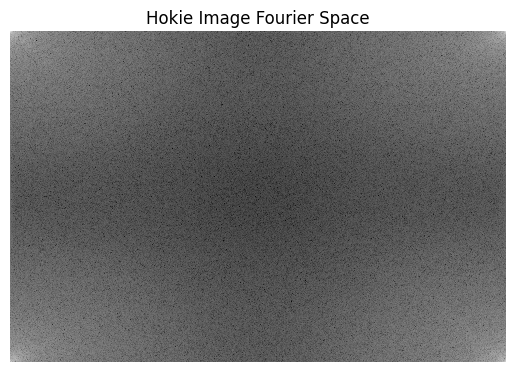

In [57]:
#2D Fourier Transform of hokie image
hokie_fourier = scipy.fft.fft2(gray)
# hokie_fourier = scipy.fft.fftshift(hokie_fourier)

#log scaling is necassary since images consituent mostly gradual change of freq, meaning
plt.imshow(np.log(1+np.abs(hokie_fourier)), cmap='gray', interpolation='nearest')
plt.title(f"Hokie Image Fourier Space")
plt.axis('off')

plt.show()

(4, 800, 1200)


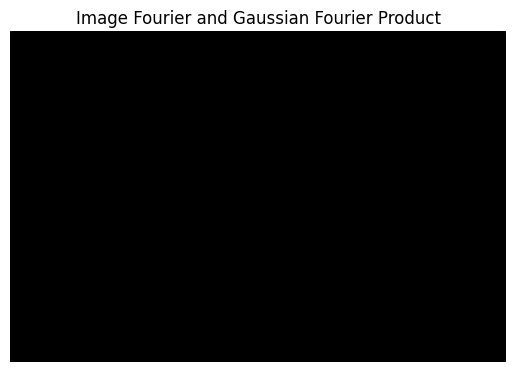

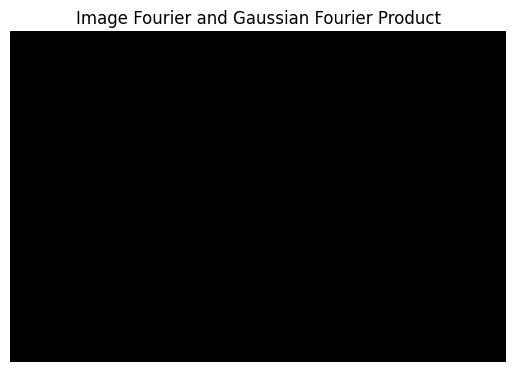

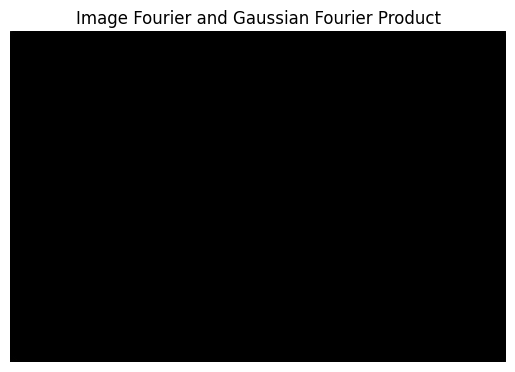

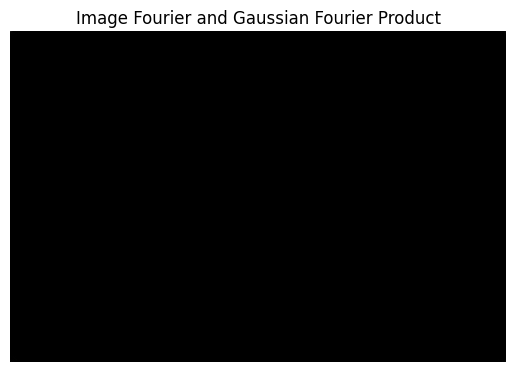

In [58]:
# print(fourier_gaussian.shape)
# print(hokie_fourier_gaussian.shape)

padding_x_top, padding_x_bottom = 375, 376
padding_y_left, padding_y_right = 575, 576

#padding must be applied before doing fourier transform, since doing it after is the same as upsampling in the spacial domain
#also, padding is causing the peak to be at the center without any shift applied and a fourier computation the center is expected to be at 0,0
padded_gaussian_fl = np.pad(
    gaussian_fl,
    ((0, 0), (padding_x_top, padding_x_bottom), (padding_y_left, padding_y_right)),
    mode='constant',
    constant_values=0
)

padded_fourier_gaussian = scipy.fft.ifftshift(padded_gaussian_fl)
padded_fourier_gaussian = scipy.fft.fft2(padded_fourier_gaussian)

print(padded_fourier_gaussian.shape)

#fourier_gaussian_product = np.dot(fourier_gaussian, hokie_fourier_gaussian.T)
fourier_gaussian_product = padded_fourier_gaussian * hokie_fourier

for i in range(len(fourier_gaussian_product)):
  # left: Gaussian filter
  plt.imshow(np.abs(fourier_gaussian_product[i]), cmap='gray', interpolation='nearest')
  plt.title(f"Image Fourier and Gaussian Fourier Product")
  plt.axis('off')

  plt.show()

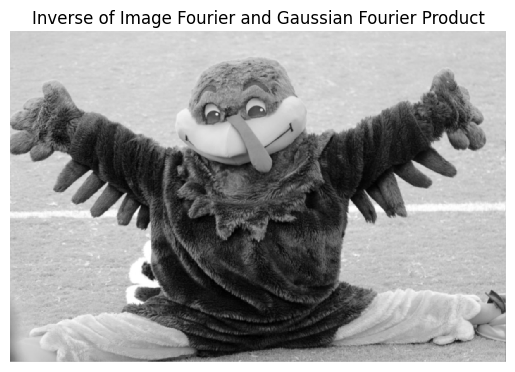

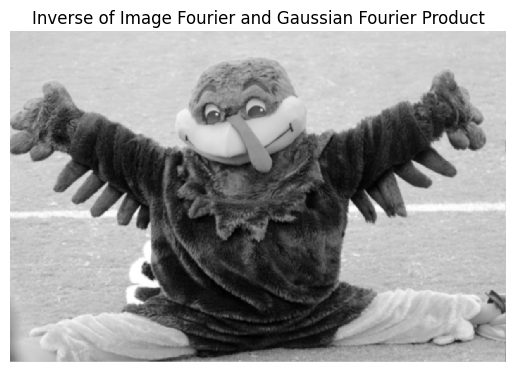

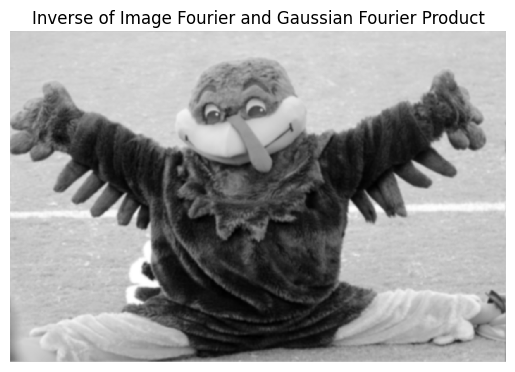

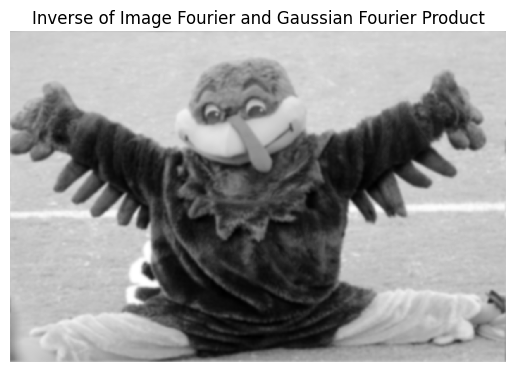

In [59]:
#DFT assumes the image is periodic(left edge wraps around the right edge)
fourier_gaussian_product = scipy.fft.ifftshift(fourier_gaussian_product)
inverse_fourier_hokie = scipy.fft.ifft2(fourier_gaussian_product)


for i in range(len(inverse_fourier_hokie)):
  # left: Gaussian filter
  plt.imshow(np.abs(inverse_fourier_hokie[i]), cmap='gray', interpolation='nearest')
  plt.title(f"Inverse of Image Fourier and Gaussian Fourier Product")
  plt.axis('off')

  plt.show()